<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filters

## 前準備

配色を定義。
詳細は [matplotlib - List of named colors](https://matplotlib.org/stable/gallery/color/named_colors.html#tableau-palette) を参照。

In [1]:
from matplotlib.colors import TABLEAU_COLORS

BLUE = TABLEAU_COLORS["tab:blue"]
ORANGE = TABLEAU_COLORS["tab:orange"]
GREEN = TABLEAU_COLORS["tab:green"]
RED = TABLEAU_COLORS["tab:red"]
PURPLE = TABLEAU_COLORS["tab:purple"]

## 使用する運動モデル

円運動モデル
\begin{equation}
\begin{pmatrix}
x \\ y
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta \\
\sin\theta
\end{pmatrix}
\end{equation}

In [2]:
import numpy as np

DT = 2 * np.pi / 100

def create_points():
    t = np.arange(0, 2*np.pi, DT)
    x = np.sin(t)
    y = np.cos(t)
    points = np.vstack((x, y)).T
    return points

points = create_points()

軌跡のアニメーション作成

<ipython-input-3-8af73df2f3a8>:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cur_pos_plt.set_data(points[i, 0], points[i, 1])


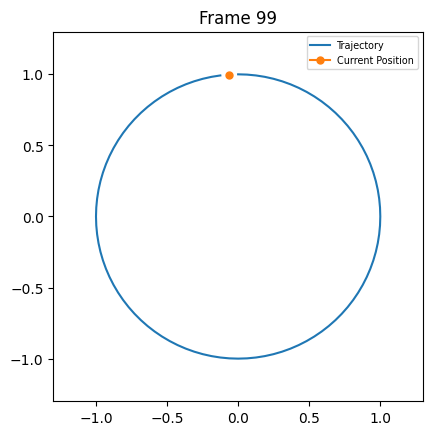

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def traj_anim(points):
    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    traj_plt, = ax.plot([], [], c=BLUE, label="Trajectory")
    cur_pos_plt, = ax.plot(
        [], [], c=ORANGE, marker="o", markersize=5,
        label="Current Position")
    ax.legend(loc="upper right", fontsize="x-small")

    def anim_callback(i):
        ax.set_title(f"Frame {i}")
        traj_plt.set_data(points[:i, 0], points[:i, 1])
        cur_pos_plt.set_data(points[i, 0], points[i, 1])

    ani = animation.FuncAnimation(fig, anim_callback, frames=points.shape[0])
    ani.save("move.gif", writer="pillow")

traj_anim(points)

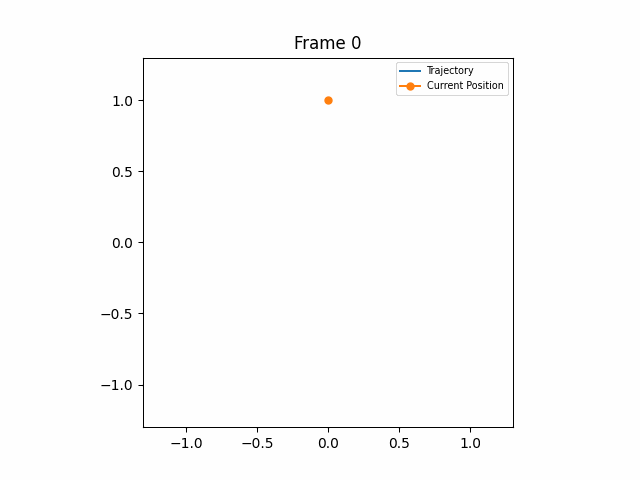

In [4]:
import IPython
from IPython.display import Image

# アニメーション再生
Image("./move.gif", format='png')

## EKF

EKF は非線形運動モデルを線形近似して Kalman Filter を適用するだけ。
Kalman Filter の公式は[ここ](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%AB%E3%83%9E%E3%83%B3%E3%83%95%E3%82%A3%E3%83%AB%E3%82%BF%E3%83%BC)を参照。

今回の EKF での運動モデルの近似式は次の通り。
\begin{equation}
\begin{pmatrix}
x_{k+1} \\ y_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta_{k+1} \\ \sin\theta_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos(\theta_k+\delta\theta) \\ \sin(\theta_k+\delta\theta)
\end{pmatrix}
=
\begin{pmatrix}
1 & -\delta\theta \\
\delta\theta & 1
\end{pmatrix}
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+\frac{1}{2}
\begin{pmatrix}
 \cos\theta_0\delta\theta^2 \\
 \sin\theta_0\delta\theta^2
\end{pmatrix}
+\mathcal{O}(\delta\theta^3)
\end{equation}

誤差絶対値の上限値を用いて次の近似をする。
\begin{equation}
\begin{pmatrix}
x_{k+1} \\ y_{k+1}
\end{pmatrix}
\simeq
\begin{pmatrix}
1 & -\delta\theta \\
\delta\theta & 1
\end{pmatrix}
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+w_k,\quad
w_k\sim N\left(0,\frac{1}{2}\delta\theta^2I\right)
\end{equation}

観測モデルは$(x,y)$変数の多変量正規分布とする。
\begin{equation}
\begin{pmatrix}
x_k' \\ y_k'
\end{pmatrix}
=
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+ v_k,\quad
v_k\sim N(0,\sigma^2 I)
\end{equation}

差分化の刻み幅（FPS）は短いほど拡張カルマンフィルタの精度は良くなる。

In [5]:
from abc import ABC, abstractmethod

class Tracking(ABC):
    def __init__(
            self, state: np.ndarray, state_error: np.ndarray,
            pred_error: np.ndarray,obs_error: np.ndarray):
        self.state = state
        self.state_error = state_error
        self.pred_error = pred_error
        self.obs_error = obs_error

    @abstractmethod
    def predict(self):
        pass

    @abstractmethod
    def update(self, observation: np.ndarray):
        pass

In [6]:
NOISE_SIGMA = 0.4


class EKF(Tracking):
    def __init__(
            self, state: np.ndarray, state_error: np.ndarray,
            pred_mat: np.ndarray, pred_error: np.ndarray,
            obs_mat: np.ndarray, obs_error: np.ndarray):
        super().__init__(state, state_error, pred_error, obs_error)
        self.pred_mat = pred_mat
        self.obs_mat = obs_mat

    def predict(self):
        self.state = self.state @ self.pred_mat
        self.state_error = (
            self.pred_mat @ self.state_error @ self.pred_mat.T
            + self.pred_error
        )

    def update(self, observation: np.ndarray):
        # カルマンゲインを計算
        innovation = observation - self.state @ self.obs_mat
        innovation_cov = (
            self.obs_mat @ self.state_error @ self.obs_mat.T
            + self.obs_error
        )
        kalman_gain = (
            self.state_error @ self.obs_mat @ np.linalg.inv(innovation_cov)
        )

        # フィルタリング
        self.state = self.state + kalman_gain @ innovation
        self.state_error = (
            (np.eye(len(self.state)) - kalman_gain) @ self.state_error
        )

正規分布ノイズを与えて疑似観測データを作成

In [7]:
def create_obs(points):
    noise = np.random.normal(0, NOISE_SIGMA**2, (points.shape[0], 2))
    points_obs = points + noise
    return points_obs

points_obs = create_obs(points)

EKF 実行

In [8]:
def ekf_integrate(points_obs):
    # 初期状態作成
    init_state = points_obs[0, :]
    init_state_error =np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])

    # EKF モデル作成
    pred_mat = np.array([[1, -DT], [DT, 1]])
    pred_error = np.array([[0.5*DT**2, 0], [0, 0.5*DT**2]])
    obs_mat = np.eye(2)
    obs_error = np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])
    ekf_filter = EKF(state=init_state, state_error=init_state_error,
                     pred_mat=pred_mat, pred_error=pred_error,
                     obs_mat=obs_mat, obs_error=obs_error)

    # 予測状態・カルマンフィルタ後の状態を初期化
    pred_states = [np.array([0, 1])]
    filtered_states = [init_state]
    filtered_state_errors = [init_state_error]

    # 逐次ステップ計算
    for i in range(0, points_obs.shape[0]-1):
        # フィルタなし予測
        pred_state = pred_states[-1] @ ekf_filter.pred_mat
        pred_states.append(pred_state)

        # カルマンフィルタ
        ekf_filter.predict()
        ekf_filter.update(points_obs[i+1, :])
        filtered_states.append(ekf_filter.state)
        filtered_state_errors.append(ekf_filter.state_error)

    # np.ndarray に変換
    pred_states = np.vstack(pred_states)
    filtered_states = np.vstack(filtered_states)
    filtered_state_errors = np.dstack(filtered_state_errors)

    return pred_states, filtered_states, filtered_state_errors

誤差共分散行列を楕円で表すためのヘルパー関数

In [9]:
def cov2ellipse(cov: np.ndarray):
    eig_val, eig_vec = np.linalg.eigh(cov)
    angle = np.arctan2(eig_vec[1, 0], eig_vec[0, 0])
    width = np.sqrt(eig_val[0])
    height = np.sqrt(eig_val[1])
    return width, height, angle

GT・予測データ・観測データ・フュージョン結果を誤差分布付きで描画

<ipython-input-10-2810c158b8dd>:41: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  gt_pos_plt.set_data(points[i, 0], points[i, 1])
<ipython-input-10-2810c158b8dd>:48: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pred_pos_plt.set_data(pred_state[i, 0], pred_state[i, 1])
<ipython-input-10-2810c158b8dd>:50: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  kalman_pos_plt.set_data(joint_state[i, 0], joint_state[i, 1])


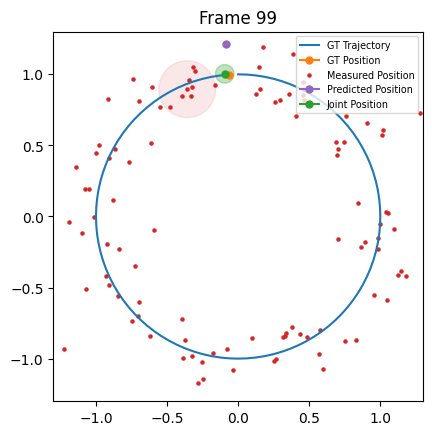

In [10]:
from matplotlib.patches import Ellipse

def ekf_anim(points, points_obs):
    pred_state, joint_state, joint_state_error = ekf_integrate(points_obs)

    x = points_obs[:, 0]
    y = points_obs[:, 1]

    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    gt_traj_plt, = ax.plot([], [], c=BLUE, label="GT Trajectory")
    gt_pos_plt, = ax.plot(
        [], [], c=ORANGE, marker="o", markersize=5, label="GT Position")

    obs_pos_scat = ax.scatter([], [], s=5, c=RED, label="Measured Position")
    obs_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=RED, alpha=0.1, animated=True)
    ax.add_patch(obs_ellipse)

    pred_pos_plt, = ax.plot(
        [], [], c=PURPLE, marker="o", markersize=5, label="Predicted Position")
    kalman_pos_plt, = ax.plot(
        [], [], c=GREEN, marker="o", markersize=5, label="Joint Position")
    kalman_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=GREEN, alpha=0.3, animated=True)
    ax.add_patch(kalman_ellipse)

    ax.legend(loc="upper right", fontsize="x-small")

    def anim_callback(i):
        ax.set_title(f"Frame {i}")

        # 正解
        gt_traj_plt.set_data(points[:i+1, 0], points[:i+1, 1])
        gt_pos_plt.set_data(points[i, 0], points[i, 1])

        # 観測点
        obs_pos_scat.set_offsets(points_obs[:i+1, :])
        obs_ellipse.set_center(points_obs[i, :])

        # 予測点
        pred_pos_plt.set_data(pred_state[i, 0], pred_state[i, 1])
        # フィルタ点
        kalman_pos_plt.set_data(joint_state[i, 0], joint_state[i, 1])

        # フィルタ誤差
        width, height, angle = cov2ellipse(joint_state_error[:, :, i])
        kalman_ellipse.set_center([joint_state[i, 0], joint_state[i, 1]])
        kalman_ellipse.set_width(width)
        kalman_ellipse.set_height(height)
        kalman_ellipse.set_angle(angle)

    ani = animation.FuncAnimation(fig, anim_callback, frames=len(x))
    ani.save("ekf.gif", writer="pillow")

ekf_anim(points, points_obs)

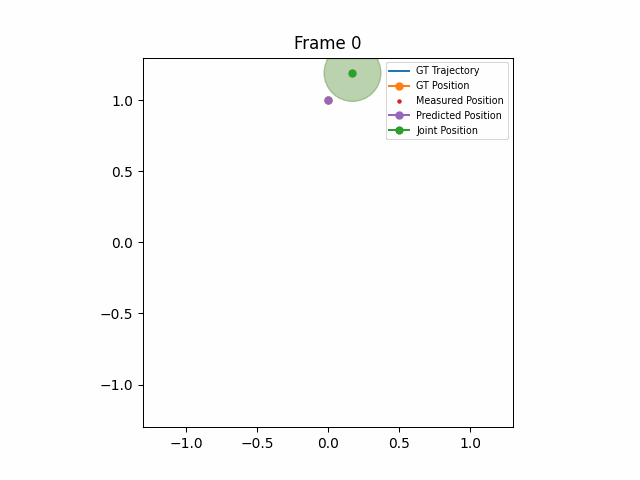

In [11]:
Image("./ekf.gif", format='png')

## UKF

シグマ点
\begin{align}
&\vec{s}^0=\vec{\mu},\quad
w_m^0=\frac{\lambda}{n+\lambda},\quad
w_c^0=\frac{\lambda}{n+\lambda}+(1-\alpha^2+\beta), \\
&\vec{s}^i=\vec{\mu}+\sqrt{n+\lambda}\sqrt{\Sigma}_{\lceil i\rceil}, \quad
\vec{s}^{i+n}=\vec{\mu}-\sqrt{n+\lambda}\sqrt{\Sigma}_{\lceil i\rceil}, \\
&w_m^i=w_c^i=\frac{1}{2(n+\lambda)},\quad
i=1,2,\ldots,n\,\\
&\kappa\leq0,\quad\alpha\in[0,1],\quad
\lambda=\alpha^2(n+\kappa)-n,\quad\beta=2
\end{align}

In [16]:
from typing import Callable
import numpy as np

class UKF(Tracking):
    def __init__(
            self, state: np.ndarray, state_error: np.ndarray,
            pred_map: Callable[[np.ndarray], np.ndarray], pred_error: np.ndarray,
            obs_map: Callable[[np.ndarray], np.ndarray], obs_error: np.ndarray,
            alpha: float=1e-3, beta: float=2, kappa: float=0):
        super().__init__(state, state_error, pred_error, obs_error)

        self.pred_map = pred_map
        self.obs_map = obs_map

        self.sigma_points = None

        # パラメータ
        n = state.shape[0]
        self.lambda_ = alpha**2 * (n + kappa) - n

        # ウェイト
        w_0_m = self.lambda_ / (n + self.lambda_)
        w_0_c = self.lambda_ / (n + self.lambda_) + (1 - alpha**2 + beta)
        w_i = 1 / (2 * (n + self.lambda_))
        self.w_m = np.block([w_0_m, *(w_i * np.ones(2*n))])
        self.w_c = np.array([w_0_c, *(w_i * np.ones(2*n))])

    def predict(self):
        self.update_sigma_points()

        self.sigma_points = np.array([
            self.pred_map(sigma_point)
            for sigma_point in self.sigma_points
        ])

        self.state = np.average(self.sigma_points, axis=0, weights=self.w_m)
        self.state_error = np.average(
            np.array([
                np.outer(
                    (self.sigma_points[idx] - self.state),
                    (self.sigma_points[idx] - self.state))
                for idx in range(len(self.sigma_points))]),
            axis=0, weights=self.w_c
        ) + self.pred_error

    def update(self, observation: np.ndarray):
        sigma_obs_points = np.array([
            self.obs_map(sigma_point)
            for sigma_point in self.sigma_points
        ])

        z_mu = np.average(sigma_obs_points, axis=0, weights=self.w_m)
        z_error = np.average(
            np.array([
                np.outer(
                    (sigma_obs_points[idx] - z_mu),
                    (sigma_obs_points[idx] - z_mu).T)
                for idx in range(len(sigma_obs_points))]),
            axis=0, weights=self.w_c
        )

        xz_error = np.average(
            np.array([
                np.outer(
                    (self.sigma_points[idx] - self.state),
                    (sigma_obs_points[idx] - z_mu).T)
                for idx in range(len(sigma_obs_points))]),
            axis=0, weights=self.w_c
        )

        # フィルタリング
        kalman_gain = xz_error @ np.linalg.inv(z_error)
        self.state = (
            self.state + kalman_gain @ (observation - z_mu)
        )
        self.state_error = (
            self.state_error - kalman_gain @ xz_error.T
        )

    def update_sigma_points(self):
        n = self.state.shape[0]
        sqrt_cov = np.linalg.cholesky(self.state_error)

        sigma_plus_points = np.array([
            self.state + np.sqrt(n + self.lambda_) * sqrt_cov[:, i]
            for i in range(n)
        ])
        sigma_minus_points = np.array([
            self.state - np.sqrt(n + self.lambda_) * sqrt_cov[:, i]
            for i in range(n)
        ])

        self.sigma_points = np.vstack(
            [self.state, sigma_plus_points, sigma_minus_points])

In [17]:
def ukf_integrate(points_obs):
    # 初期状態作成
    init_state = points_obs[0, :]
    init_state_error =np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])

    # UKF モデル作成
    pred_map = lambda x: x @ np.array([
        [np.cos(DT), -np.sin(DT)], [np.sin(DT), np.cos(DT)]])
    pred_error = np.array([[0.5*DT**2, 0], [0, 0.5*DT**2]])
    obs_map = lambda x: x
    obs_error = np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])
    ukf_filter = UKF(state=init_state, state_error=init_state_error,
                     pred_map=pred_map, pred_error=pred_error,
                     obs_map=obs_map, obs_error=obs_error)

    # 予測状態・カルマンフィルタ後の状態を初期化
    pred_states = [np.array([0, 1])]
    filtered_states = [init_state]
    filtered_state_errors = [init_state_error]

    # 逐次ステップ計算
    for i in range(0, points_obs.shape[0]-1):
        # フィルタなし予測
        pred_state = pred_map(pred_states[-1])
        pred_states.append(pred_state)

        # カルマンフィルタ
        ukf_filter.predict()
        ukf_filter.update(points_obs[i+1, :])
        filtered_states.append(ukf_filter.state)
        filtered_state_errors.append(ukf_filter.state_error)

    # np.ndarray に変換
    pred_states = np.vstack(pred_states)
    filtered_states = np.vstack(filtered_states)
    filtered_state_errors = np.dstack(filtered_state_errors)

    return pred_states, filtered_states, filtered_state_errors

<ipython-input-18-5ba4e09a8581>:39: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  gt_pos_plt.set_data(points[i, 0], points[i, 1])
<ipython-input-18-5ba4e09a8581>:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pred_pos_plt.set_data(pred_state[i, 0], pred_state[i, 1])
<ipython-input-18-5ba4e09a8581>:48: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  kalman_pos_plt.set_data(filtered_state[i, 0], filtered_state[i, 1])


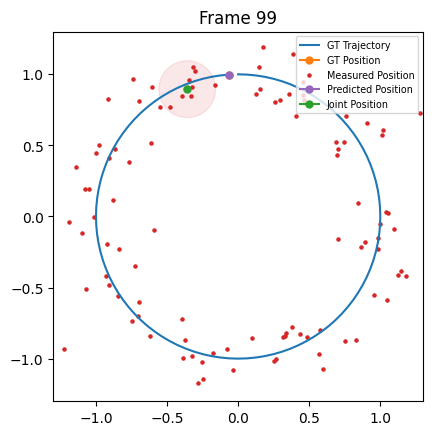

In [18]:
def ukf_anim(points, points_obs):
    pred_state, filtered_state, filtered_state_error = ukf_integrate(points_obs)

    x = points_obs[:, 0]
    y = points_obs[:, 1]

    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    gt_traj_plt, = ax.plot([], [], c=BLUE, label="GT Trajectory")
    gt_pos_plt, = ax.plot(
        [], [], c=ORANGE, marker="o", markersize=5, label="GT Position")

    obs_pos_scat = ax.scatter([], [], s=5, c=RED, label="Measured Position")
    obs_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=RED, alpha=0.1, animated=True)
    ax.add_patch(obs_ellipse)

    pred_pos_plt, = ax.plot(
        [], [], c=PURPLE, marker="o", markersize=5, label="Predicted Position")
    kalman_pos_plt, = ax.plot(
        [], [], c=GREEN, marker="o", markersize=5, label="Joint Position")
    kalman_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=GREEN, alpha=0.3, animated=True)
    ax.add_patch(kalman_ellipse)

    ax.legend(loc="upper right", fontsize="x-small")

    def anim_callback(i):
        ax.set_title(f"Frame {i}")

        # 正解
        gt_traj_plt.set_data(points[:i+1, 0], points[:i+1, 1])
        gt_pos_plt.set_data(points[i, 0], points[i, 1])

        # 観測点
        obs_pos_scat.set_offsets(points_obs[:i+1, :])
        obs_ellipse.set_center(points_obs[i, :])

        # 予測点
        pred_pos_plt.set_data(pred_state[i, 0], pred_state[i, 1])
        # フィルタ点
        kalman_pos_plt.set_data(filtered_state[i, 0], filtered_state[i, 1])

        # フィルタ誤差
        width, height, angle = cov2ellipse(filtered_state_error[:, :, i])
        kalman_ellipse.set_center([filtered_state[i, 0], filtered_state[i, 1]])
        kalman_ellipse.set_width(width)
        kalman_ellipse.set_height(height)
        kalman_ellipse.set_angle(angle)

    ani = animation.FuncAnimation(fig, anim_callback, frames=len(x))
    ani.save("ukf.gif", writer="pillow")

ukf_anim(points, points_obs)

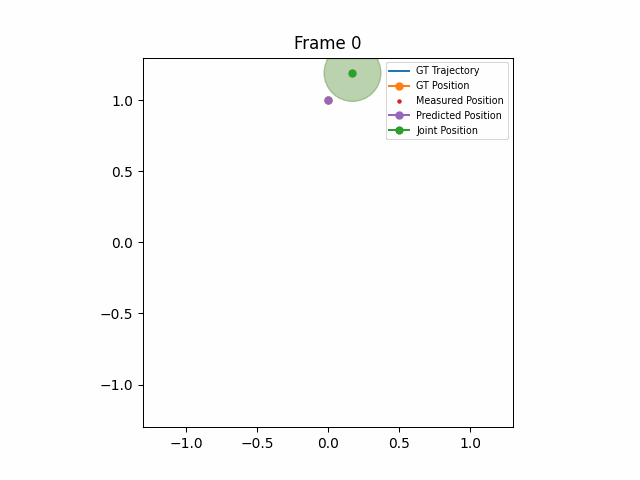

In [19]:
Image("./ukf.gif", format='png')